In [1]:
# import event simulation files
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt
import csv

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Selected device is',device)

Selected device is cpu


## Data processing

In [3]:
n_evt = 100000
n_evt_test = 5000
n_evt_val = 10000

evt_arr,      muon_list,      max_n      = ge.generate_noisy_evts(n_evt,      noise_frac=0.5, bkg_frac=0.3)
evt_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(n_evt_test, noise_frac=0.5, bkg_frac=0.3)
evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|██████████| 10000/10000 [00:09<00:00, 1068.13it/s]


In [4]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr      = convert_to(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
mu_arr_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [5]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True):

    spike_data = torch.zeros(size=(num_step, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step, batch_size, -1)
                
    return spike_data    

In [6]:
def gen_target_cell(muon_list, linearise=True):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1
    target = torch.tensor(target, dtype=torch.long)
    if linearise:
        target = target.view(len(muon_list), -1)

    return target

In [7]:
def filter_noise(muon_list):
    target_list=[]
    
    for event in muon_list:
        target_event=[]
        for hit in event:
            
            if hit["signal"] == True:
                target_event.append(hit)
        
        target_list.append(target_event)
        
    return target_list

def gen_target_timing(muon_list, size, target_dtype, features):
    filtered_list = filter_noise(muon_list)
    return convert_to(filtered_list, size, target_dtype, features)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

In [9]:
target      = gen_target_cell(muon_list)
target_test = gen_target_cell(muon_list_test)
target_val  = gen_target_cell(muon_list_val)

train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=nw)

100000it [00:00, 295511.50it/s]
5000it [00:00, 312653.11it/s]
10000it [00:00, 327710.72it/s]


## Network definitions

In [10]:
# Network Architecture 1
num_inputs1 = ps.NLAYERS*ps.NWIRES
num_hidden1 = 100
num_outputs_cell1 = 2*num_inputs1

num_steps1 = 40
beta1 = 0.8
threshold1=0.9

# Network Architecture 2
num_inputs2 = ps.NLAYERS*ps.NWIRES
num_hidden2 = [20,20,20]
num_outputs_cell2 = 2*num_inputs2

num_steps2 = 40
beta2 = 0.8
alpha2 =0.8
threshold2=0.9

# Network Architecture 3
num_inputs3 = ps.NLAYERS*ps.NWIRES
num_hidden3 = 30
num_outputs_cell3 = 2*num_inputs3

num_steps3 = 40
beta3 = 0.8
threshold3=0.9

# Network Architecture 4
num_inputs4 = ps.NLAYERS*ps.NWIRES
num_hidden4 = 100
num_outputs_cell4 = 2*num_inputs4

num_steps4 = 40
beta4 = 0.5
threshold4=0.9

# Network Architecture 5
num_inputs5 = ps.NLAYERS*ps.NWIRES
num_hidden5 = 100
num_outputs_cell5 = 2*num_inputs5

num_steps5 = 40
beta5 = 0.8
alpha5 =0.8
threshold5=0.9

# Network Architecture 6
num_inputs6 = ps.NLAYERS*ps.NWIRES
num_hidden6 = 30
num_outputs_cell6 = 2*num_inputs6

num_steps6 = 40
beta6 = 0.5
threshold6=0.9

In [11]:
class Net1layer(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta1,spike_grad=spike_grad,threshold=threshold1,
                                learn_beta=learnable,learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta1,spike_grad=spike_grad,threshold=threshold1,
                                learn_beta=learnable,learn_threshold=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [12]:
class Net1layer2ndOrder(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta1,alpha=alpha5,threshold=threshold1,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta1,alpha=alpha5,threshold=threshold1,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [13]:
class Net3layers(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=beta2,alpha=alpha2,
                                   spike_grad=spike_grad,
                                   threshold=threshold2,
                                  learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_hidden1 = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden1 = snn.Synaptic(beta=beta2,alpha=alpha2,
                                    spike_grad=spike_grad,
                                    threshold=threshold2,
                                       learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_hidden2 = nn.Linear(in_features=self.hidden[1], out_features=self.hidden[2])
        self.lif_hidden2 = snn.Synaptic(beta=beta2,alpha=alpha2,
                                    spike_grad=spike_grad,
                                    threshold=threshold2,
                                       learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden[2], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta2,alpha=alpha2,
                                    spike_grad=spike_grad,
                                    threshold=threshold2,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh1, memh1 = self.lif_hidden1.init_synaptic()
        synh2, memh2 = self.lif_hidden2.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh1 = self.fc_hidden1(spk1)
            spkh1, synh1, memh1 = self.lif_hidden1(curh1, synh1, memh1)
            
            curh2 = self.fc_hidden2(spkh1)
            spkh2, synh2, memh2 = self.lif_hidden2(curh2, synh2, memh2)
            
            cur2 = self.fc_out(spkh2)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

## Training

In [14]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func, timing):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func
        self.timing = timing

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            if self.timing:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, :, i])
            else:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, i])
        return loss

In [15]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-bymoment for precise timing recontruction
    elif type == 'mse_timing':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        correct = (output == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    elif type == 'mse_timing_per_evt':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())

    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()


    return total, correct

In [16]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, batch_size, timing, linearise, use_membrane, num_steps=40):
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        return mean_loss, acc

In [17]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type, 
              batch_size, num_steps=40, linearise=True, timing=False, use_membrane=False):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val = accuracy_set(net, val_loader, loss_fn, accuracy_type,
                                              batch_size, timing, linearise, use_membrane)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [18]:
num_epochs = 10
accuracy_type = 'cell_per_evt'

In [19]:
net1 = Net1layer(num_inputs1, num_hidden1, num_outputs_cell1, num_steps1,False).to(device)

loss_fn1 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer1 = torch.optim.Adam(net1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist1, loss_val_hist1, acc_val_hist1 = train_net(net1,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn1, optimizer1,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.274604797363281 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 10.097243309020996 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.78807258605957 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 6.111488342285156 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 5.958125114440918 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 4.755300045013428 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 3.737485408782959 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 3.0181069374084473 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 2.525377035140991 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 2.5637309551239014 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 2.5294430255889893 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.9173998832702637 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 2.0558221340179443 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 2.023318290710449 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.6186403036117554 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.7690160274505615 

Epoch: 0
Batch: 800
It

In [20]:
net2 = Net3layers(num_inputs2, num_hidden2, num_outputs_cell2, num_steps2,False).to(device)

loss_fn2 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist2, loss_val_hist2, acc_val_hist2 = train_net(net2,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn2, optimizer2,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 109.9266586303711 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 13.821410179138184 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.849514484405518 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 6.565253257751465 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 5.6534881591796875 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 5.737671375274658 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 6.182620525360107 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 5.392422199249268 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 5.232325553894043 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 5.048677921295166 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 4.537989616394043 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 4.1438422203063965 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 3.7041966915130615 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 3.0458672046661377 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 3.1066184043884277 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 2.761385440826416 

Epoch: 0
Batch: 800
Iter

In [21]:
net3 = Net1layer(num_inputs3, num_hidden3, num_outputs_cell3, num_steps3,False).to(device)

loss_fn3 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer3 = torch.optim.Adam(net3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist3, loss_val_hist3, acc_val_hist3 = train_net(net3,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn3, optimizer3,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 13.173921585083008 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 10.310281753540039 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 9.628288269042969 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 8.555252075195312 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 7.484371662139893 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 6.460492134094238 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 5.941330909729004 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 5.431138038635254 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 5.358710765838623 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 4.520480632781982 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 4.222742080688477 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 3.6823573112487793 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 2.9142560958862305 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 2.851700782775879 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 2.3008511066436768 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 2.416832685470581 

Epoch: 0
Batch: 800
Itera

In [22]:
net4 = Net1layer(num_inputs4, num_hidden4, num_outputs_cell4, num_steps4,False).to(device)

loss_fn4 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer4 = torch.optim.Adam(net4.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist4, loss_val_hist4, acc_val_hist4 = train_net(net4,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn4, optimizer4,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.096558570861816 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 9.983470916748047 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.783323764801025 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 5.402284622192383 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 5.631222248077393 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 4.412322998046875 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 3.836271286010742 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 2.835648536682129 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 2.987870454788208 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 2.38734769821167 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 2.2612433433532715 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 2.1680052280426025 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 2.2325685024261475 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.753061294555664 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.7278128862380981 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.480599045753479 

Epoch: 0
Batch: 800
Iterat

In [23]:
net5 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_cell5, num_steps5,False).to(device)

loss_fn5 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer5 = torch.optim.Adam(net5.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist5, loss_val_hist5, acc_val_hist5 = train_net(net5,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn5, optimizer5,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 139.72972106933594 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 7.699607849121094 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.445673942565918 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 5.18949556350708 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 4.613392353057861 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 3.8365447521209717 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.80696177482605 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 2.7703845500946045 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 2.4331932067871094 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 2.3842694759368896 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 1.917409062385559 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.9153705835342407 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.1002869606018066 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.2881405353546143 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.7653384208679199 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.2198996543884277 

Epoch: 0
Batch: 800
It

In [24]:
net6 = Net1layer(num_inputs1, num_hidden1, num_outputs_cell1, num_steps1,True).to(device)

loss_fn6 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer6 = torch.optim.Adam(net6.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist6, loss_val_hist6, acc_val_hist6 = train_net(net6,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn6, optimizer6,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 8.521638870239258 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.741270065307617 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 6.166797637939453 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 5.925621509552002 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 4.0610432624816895 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 3.1204276084899902 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 2.432551860809326 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 2.069244146347046 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.8189568519592285 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 1.2145154476165771 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.134476661682129 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.3174326419830322 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.1157865524291992 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.5602526664733887 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.0420293807983398 

Epoch: 0
Batch: 800
I

In [25]:
net7 = Net3layers(num_inputs2, num_hidden2, num_outputs_cell2, num_steps2,True).to(device)

loss_fn7 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer7 = torch.optim.Adam(net7.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7, loss_val_hist7, acc_val_hist7 = train_net(net7,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn7, optimizer7,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 106.81498718261719 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 32.17604446411133 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 8.296914100646973 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 7.158912658691406 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 6.607154846191406 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 6.963088512420654 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 6.679368019104004 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 5.523426532745361 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 5.0413408279418945 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 4.18488883972168 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 4.696431636810303 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 4.184019088745117 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 3.7738707065582275 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 3.7112057209014893 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 3.6350879669189453 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 4.200431823730469 

Epoch: 0
Batch: 800
Iterat

In [26]:
net8 = Net1layer(num_inputs3, num_hidden3, num_outputs_cell3, num_steps3,True).to(device)

loss_fn8 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer8 = torch.optim.Adam(net8.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist8, loss_val_hist8, acc_val_hist8 = train_net(net8,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn8, optimizer8,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 13.171385765075684 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 10.668517112731934 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 9.907784461975098 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 9.09261703491211 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 6.630002021789551 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 6.934100151062012 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 6.2402472496032715 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 5.930666923522949 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 5.974775791168213 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 4.961599826812744 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 3.97678542137146 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 3.8780438899993896 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 3.285813808441162 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 2.950287103652954 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 2.3371851444244385 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.8837867975234985 

Epoch: 0
Batch: 800
Iterat

In [27]:
net9 = Net1layer(num_inputs4, num_hidden4, num_outputs_cell4, num_steps4,True).to(device)

loss_fn9 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer9 = torch.optim.Adam(net9.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist9, loss_val_hist9, acc_val_hist9 = train_net(net9,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn9, optimizer9,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.021977424621582 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 8.692989349365234 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.356833457946777 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 5.571444511413574 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 5.557231903076172 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 3.2980360984802246 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.6369845867156982 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 2.1625123023986816 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.6323398351669312 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.4278945922851562 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 1.3668338060379028 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.0164622068405151 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.2003114223480225 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.14002525806427 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.9433168768882751 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.815779983997345 

Epoch: 0
Batch: 800
I

In [28]:
net10 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_cell5, num_steps5,True).to(device)

loss_fn10 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer10 = torch.optim.Adam(net10.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10, loss_val_hist10, acc_val_hist10 = train_net(net10,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn10, optimizer10,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 110.88479614257812 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 9.715653419494629 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.490786552429199 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 5.222423553466797 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 4.244130611419678 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 2.722050428390503 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.5152361392974854 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 1.9340132474899292 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.7971272468566895 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.6619007587432861 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 1.645592212677002 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.1964075565338135 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.1781716346740723 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.2390674352645874 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.002570629119873 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.9509665369987488 

Epoch: 0
Batch: 800
I

In [29]:
net11 = Net1layer(num_inputs6, num_hidden6, num_outputs_cell6, num_steps6,False).to(device)

loss_fn11 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer11 = torch.optim.Adam(net11.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist11, loss_val_hist11, acc_val_hist11 = train_net(net11,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn11, optimizer11,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 10.811360359191895 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 10.19456958770752 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 8.843080520629883 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 7.898201942443848 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 7.129363059997559 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 5.712943077087402 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 5.481893062591553 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 4.8040385246276855 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 4.159585475921631 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 3.80107045173645 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 3.5015454292297363 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 3.1653733253479004 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 2.73237943649292 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 2.8114750385284424 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 2.759397506713867 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 2.6198654174804688 

Epoch: 0
Batch: 800
Iterat

In [30]:
net12 = Net1layer(num_inputs6, num_hidden6, num_outputs_cell6, num_steps6,True).to(device)

loss_fn12 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer12 = torch.optim.Adam(net12.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist12, loss_val_hist12, acc_val_hist12 = train_net(net12,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn12, optimizer12,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 10.82421588897705 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 10.015998840332031 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 8.093199729919434 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 7.387405872344971 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 5.992904186248779 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 4.976834774017334 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 4.888082504272461 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 4.127645492553711 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 3.172506093978882 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 2.6887989044189453 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 2.336013078689575 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 2.073317050933838 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.9447654485702515 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.752362608909607 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.5826855897903442 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.5342693328857422 

Epoch: 0
Batch: 800
Itera

In [54]:
for i in range(1,13):
    csv_file_path = f'results/batch_size{batch_size}/output{i}.csv'
    net_name = f'net_{i}'
    
    net = globals().get(f'net{i}')
    loss_train = globals().get(f'loss_hist{i}')
    loss_val = globals().get(f'loss_val_hist{i}')
    acc = globals().get(f'acc_val_hist{i}')
    
    max_length = max(len(loss_train), len(loss_val), len(acc))

    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')

    torch.save(net.state_dict(), net_name)


CSV file "results/batch_size100/output1.csv" created successfully.
CSV file "results/batch_size100/output2.csv" created successfully.
CSV file "results/batch_size100/output3.csv" created successfully.
CSV file "results/batch_size100/output4.csv" created successfully.
CSV file "results/batch_size100/output5.csv" created successfully.
CSV file "results/batch_size100/output6.csv" created successfully.
CSV file "results/batch_size100/output7.csv" created successfully.
CSV file "results/batch_size100/output8.csv" created successfully.
CSV file "results/batch_size100/output9.csv" created successfully.
CSV file "results/batch_size100/output10.csv" created successfully.
CSV file "results/batch_size100/output11.csv" created successfully.
CSV file "results/batch_size100/output12.csv" created successfully.


### Results

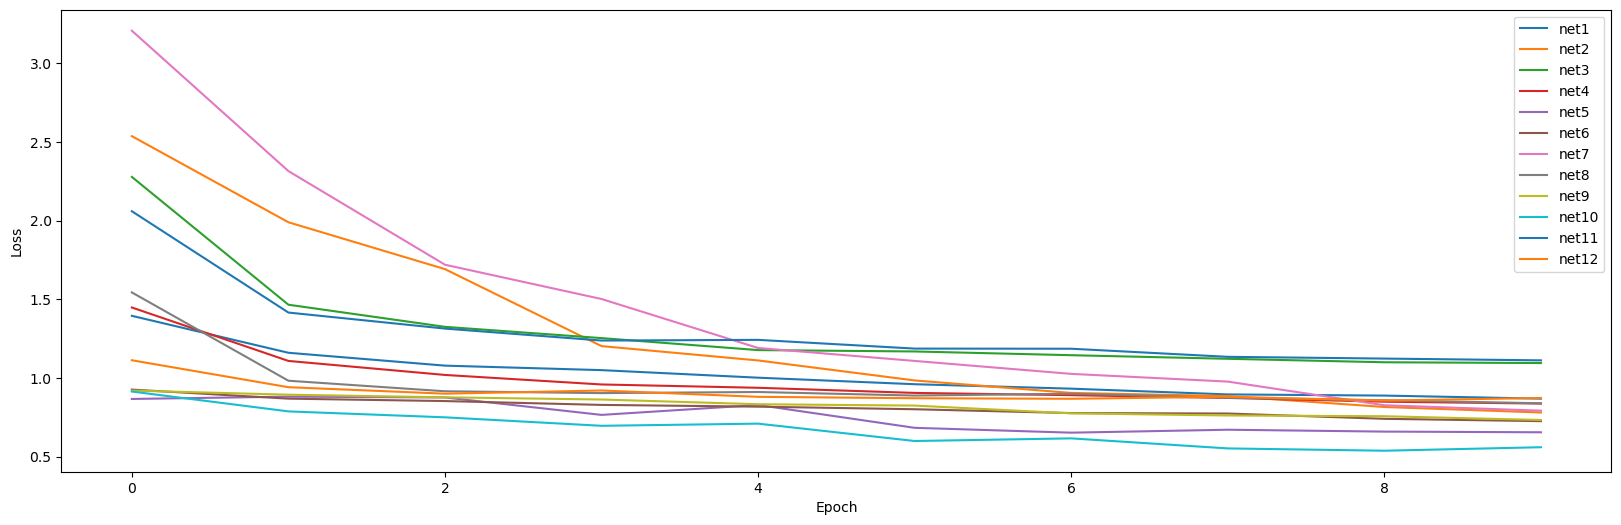

Results after 10 epochs:

Position 1: net10 - loss = 0.56
Position 2: net5 - loss = 0.655
Position 3: net6 - loss = 0.726
Position 4: net9 - loss = 0.733
Position 5: net2 - loss = 0.781
Position 6: net7 - loss = 0.792
Position 7: net4 - loss = 0.837
Position 8: net8 - loss = 0.839
Position 9: net1 - loss = 0.869
Position 10: net12 - loss = 0.873
Position 11: net3 - loss = 1.095
Position 12: net11 - loss = 1.112


In [34]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist1,label='net1')
plt.plot(loss_val_hist2,label='net2')
plt.plot(loss_val_hist3,label='net3')
plt.plot(loss_val_hist4,label='net4')
plt.plot(loss_val_hist5,label='net5')
plt.plot(loss_val_hist6,label='net6')
plt.plot(loss_val_hist7,label='net7')
plt.plot(loss_val_hist8,label='net8')
plt.plot(loss_val_hist9,label='net9')
plt.plot(loss_val_hist10,label='net10')
plt.plot(loss_val_hist11,label='net11')
plt.plot(loss_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,13):
    
    loss_val = globals().get(f'loss_val_hist{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

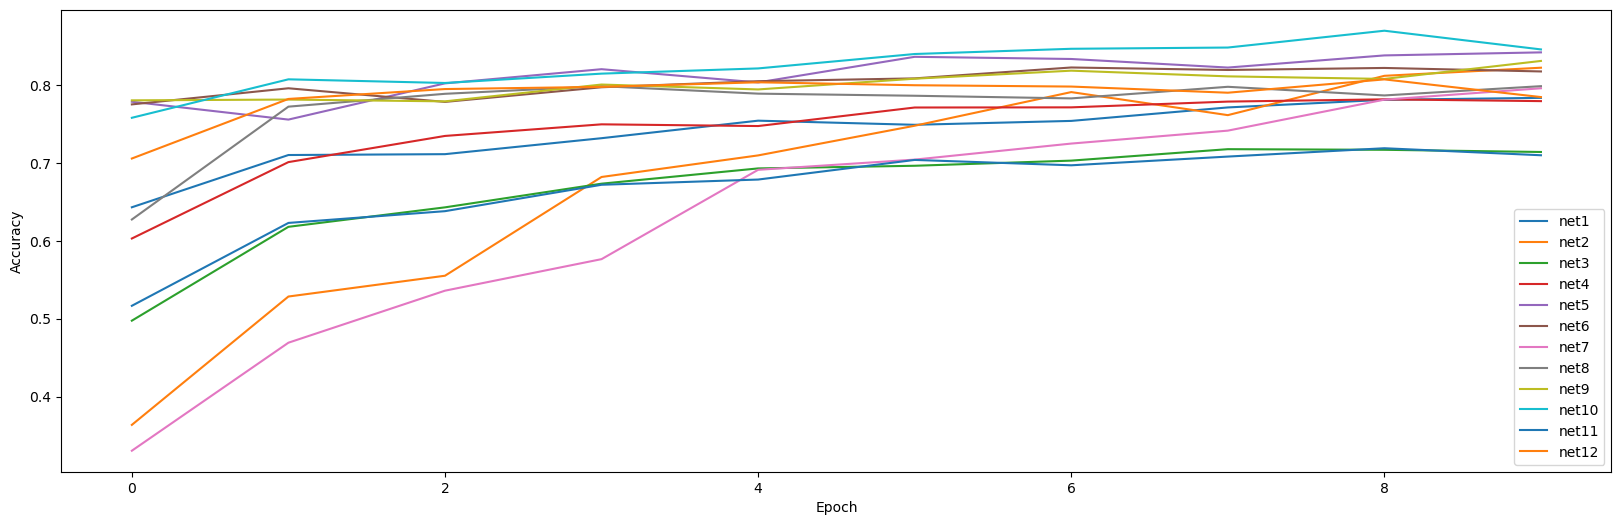

Results after 10 epochs:

Position 1: net10 - loss = 84.57%
Position 2: net5 - loss = 84.19%
Position 3: net9 - loss = 83.09%
Position 4: net2 - loss = 82.22%
Position 5: net6 - loss = 81.74%
Position 6: net8 - loss = 79.85%
Position 7: net7 - loss = 79.58%
Position 8: net12 - loss = 78.45%
Position 9: net1 - loss = 78.35%
Position 10: net4 - loss = 77.93%
Position 11: net3 - loss = 71.4%
Position 12: net11 - loss = 70.98%


In [53]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist1,label='net1')
plt.plot(acc_val_hist2,label='net2')
plt.plot(acc_val_hist3,label='net3')
plt.plot(acc_val_hist4,label='net4')
plt.plot(acc_val_hist5,label='net5')
plt.plot(acc_val_hist6,label='net6')
plt.plot(acc_val_hist7,label='net7')
plt.plot(acc_val_hist8,label='net8')
plt.plot(acc_val_hist9,label='net9')
plt.plot(acc_val_hist10,label='net10')
plt.plot(acc_val_hist11,label='net11')
plt.plot(acc_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,13):
    
    acc_val = globals().get(f'acc_val_hist{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(torch.Tensor.numpy(acc_value)*100,3)}%')

### Batch analysis

In [36]:
batch_size1 = 50
batch_size2 = 100
batch_size3 = 2000
nw=0

train_loader1 = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True, num_workers=nw)
test_loader1  = DataLoader(test_dataset,  batch_size=batch_size1, shuffle=False, num_workers=nw)
val_loader1   = DataLoader(val_dataset,   batch_size=batch_size1, shuffle=False, num_workers=nw)

train_loader2 = DataLoader(train_dataset, batch_size=batch_size2, shuffle=True, num_workers=nw)
test_loader2  = DataLoader(test_dataset,  batch_size=batch_size2, shuffle=False, num_workers=nw)
val_loader2   = DataLoader(val_dataset,   batch_size=batch_size2, shuffle=False, num_workers=nw)

train_loader3 = DataLoader(train_dataset, batch_size=batch_size3, shuffle=True, num_workers=nw)
test_loader3  = DataLoader(test_dataset,  batch_size=batch_size3, shuffle=False, num_workers=nw)
val_loader3   = DataLoader(val_dataset,   batch_size=batch_size3, shuffle=False, num_workers=nw)

#### Net7

In [37]:
net7_batch1 = Net3layers(num_inputs2, num_hidden2, num_outputs_cell2, num_steps2,True).to(device)

loss_fn7_batch1 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer7_batch1 = torch.optim.Adam(net7_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch1, loss_val_hist7_batch1, acc_val_hist7_batch1 = train_net(net7_batch1,
                                                   train_loader1, val_loader1,
                                                   num_epochs, loss_fn7_batch1, optimizer7_batch1,
                                                   accuracy_type, batch_size1)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 160.8049774169922 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 42.96099853515625 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 28.0234317779541 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 9.492133140563965 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 6.2693562507629395 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 6.038891315460205 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 6.9171271324157715 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 6.49055290222168 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 6.64865779876709 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 6.114472389221191 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 5.778962135314941 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 5.077496528625488 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 4.9540276527404785 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 4.416226387023926 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 4.51022481918335 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 5.024405479431152 

Epoch: 0
Batch: 800
Iteration: 

In [38]:
net7_batch2 = Net3layers(num_inputs2, num_hidden2, num_outputs_cell2, num_steps2,True).to(device)

loss_fn7_batch2 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer7_batch2 = torch.optim.Adam(net7_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch2, loss_val_hist7_batch2, acc_val_hist7_batch2 = train_net(net7_batch2,
                                                   train_loader2, val_loader2,
                                                   num_epochs, loss_fn7_batch2, optimizer7_batch2,
                                                   accuracy_type, batch_size2)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 77.0738525390625 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 31.966915130615234 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 7.225747585296631 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 7.210551738739014 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 7.0772929191589355 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 7.052104949951172 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 6.897502899169922 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 6.808816909790039 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 6.308821678161621 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 5.430518627166748 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 4.715206146240234 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 3.68737530708313 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 3.1506781578063965 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 3.6102218627929688 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 2.844967842102051 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 2.8265132904052734 

Epoch: 0
Batch: 800
Iterati

In [39]:
net7_batch3 = Net3layers(num_inputs2, num_hidden2, num_outputs_cell2, num_steps2,True).to(device)

loss_fn7_batch3 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer7_batch3 = torch.optim.Adam(net7_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch3, loss_val_hist7_batch3, acc_val_hist7_batch3 = train_net(net7_batch3,
                                                   train_loader3, val_loader3,
                                                   num_epochs, loss_fn7_batch3, optimizer7_batch3,
                                                   accuracy_type, batch_size3)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 53.166770935058594 

Validation Set Loss: 10.038076591491699
Validation Set Accuracy: 26.95%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 50
Loss: 9.931827545166016 

Validation Set Loss: 8.007186603546142
Validation Set Accuracy: 27.66%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 100
Loss: 8.028060913085938 

Validation Set Loss: 6.275978660583496
Validation Set Accuracy: 28.65%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 150
Loss: 6.19476842880249 

Validation Set Loss: 5.627739715576172
Validation Set Accuracy: 29.10%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 200
Loss: 5.616576194763184 

Validation Set Loss: 5.187236881256103
Validation Set Accuracy: 28.67%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 250
Loss: 5.073919296264648 

Validation Set Loss: 4.83701

In [55]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net7_{i}.csv'
    net_name = f'net_7_{i}'
    
    net = globals().get(f'net7_batch{i}')
    
    loss_train = globals().get(f'loss_hist7_batch{i}')
    loss_val = globals().get(f'loss_val_hist7_batch{i}')
    acc = globals().get(f'acc_val_hist7_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')
    torch.save(net.state_dict(), net_name)

CSV file "results/batch_test/output_net7_1.csv" created successfully.
CSV file "results/batch_test/output_net7_2.csv" created successfully.
CSV file "results/batch_test/output_net7_3.csv" created successfully.


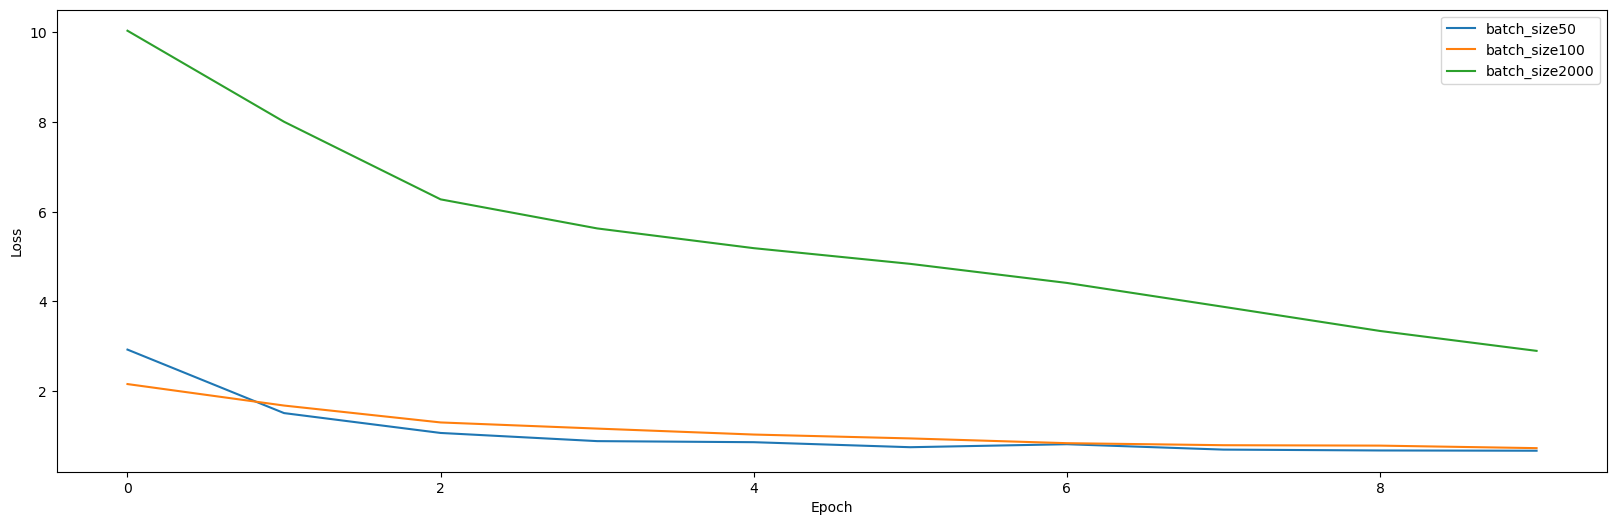

Results after 10 epochs:

Position 1: net1 - loss = 0.668
Position 2: net2 - loss = 0.726
Position 3: net3 - loss = 2.896


In [41]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist7_batch1,label='batch_size50')
plt.plot(loss_val_hist7_batch2,label='batch_size100')
plt.plot(loss_val_hist7_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist7_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

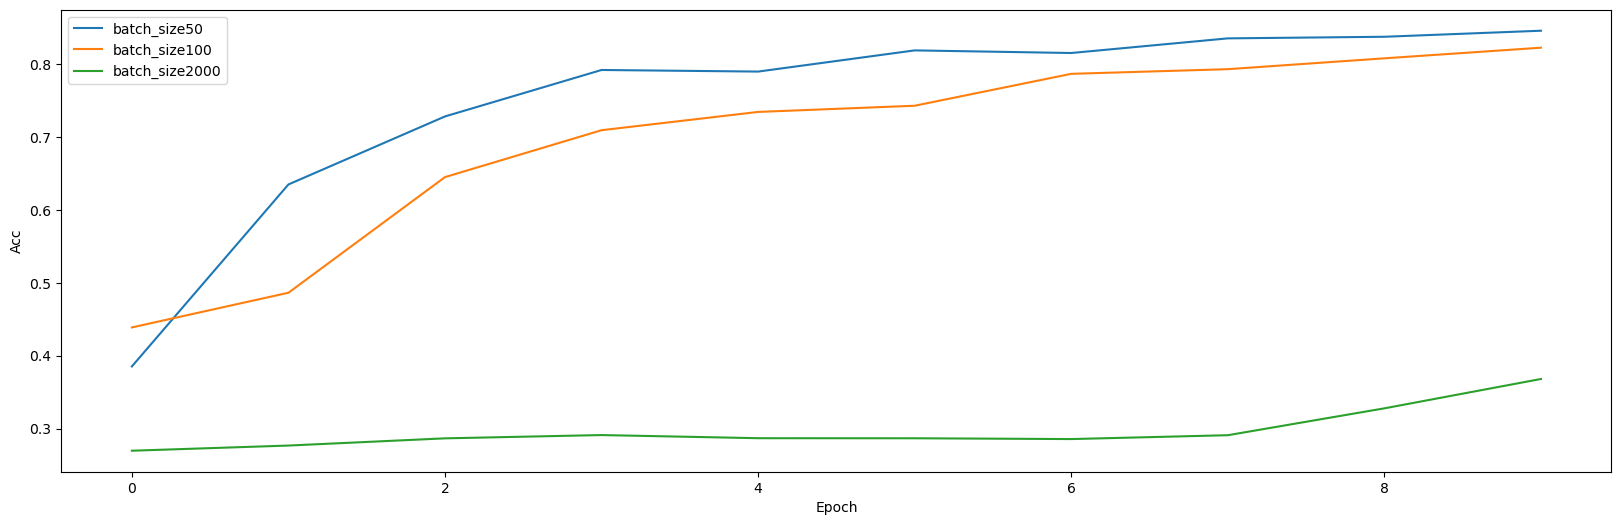

Results after 10 epochs:

Position 1: net1 - loss = 84.62%
Position 2: net2 - loss = 82.29%
Position 3: net3 - loss = 36.8%


In [52]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist7_batch1,label='batch_size50')
plt.plot(acc_val_hist7_batch2,label='batch_size100')
plt.plot(acc_val_hist7_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist7_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(torch.Tensor.numpy(acc_value)*100,3)}%')

#### Net10

In [43]:
net10_batch1 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_cell5, num_steps5,True).to(device)

loss_fn10_batch1 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer10_batch1 = torch.optim.Adam(net10_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch1, loss_val_hist10_batch1, acc_val_hist10_batch1 = train_net(net10_batch1,
                                                   train_loader1, val_loader1,
                                                   num_epochs, loss_fn10_batch1, optimizer10_batch1,
                                                   accuracy_type, batch_size1)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 137.61509704589844 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 8.602537155151367 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 7.101523399353027 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 5.248617172241211 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 4.494931221008301 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 3.849433660507202 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.71321177482605 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 2.55519437789917 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 2.6947572231292725 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 2.112969160079956 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 2.127371311187744 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.3625699281692505 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.711687445640564 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.960839033126831 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 1.4002310037612915 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 1.126345157623291 

Epoch: 0
Batch: 800
Iteratio

In [44]:
net10_batch2 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_cell5, num_steps5,True).to(device)

loss_fn10_batch2 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer10_batch2 = torch.optim.Adam(net10_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch2, loss_val_hist10_batch2, acc_val_hist10_batch2 = train_net(net10_batch2,
                                                   train_loader2, val_loader2,
                                                   num_epochs, loss_fn10_batch2, optimizer10_batch2,
                                                   accuracy_type, batch_size2)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 92.35132598876953 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 8.805437088012695 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 5.5606465339660645 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 4.1357622146606445 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 3.624439001083374 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 2.5259928703308105 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.0966272354125977 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 1.909401774406433 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.6208702325820923 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.668602705001831 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 1.4642510414123535 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.2311005592346191 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 1.3994786739349365 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 1.0969656705856323 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.7888272404670715 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.7299275398254395 

Epoch: 0
Batch: 800

In [45]:
net10_batch3 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_cell5, num_steps5,True).to(device)

loss_fn10_batch3 = Multi_loss(2, SF.ce_count_loss(), False)
optimizer10_batch3 = torch.optim.Adam(net10_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch3, loss_val_hist10_batch3, acc_val_hist10_batch3 = train_net(net10,
                                                   train_loader3, val_loader3,
                                                   num_epochs, loss_fn10_batch3, optimizer10_batch3,
                                                   accuracy_type, batch_size3)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.5817606449127197 

Validation Set Loss: 0.5599430799484253
Validation Set Accuracy: 84.57%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 50
Loss: 0.5501314997673035 

Validation Set Loss: 0.5599430799484253
Validation Set Accuracy: 84.57%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 100
Loss: 0.5313417911529541 

Validation Set Loss: 0.5599430799484253
Validation Set Accuracy: 84.57%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 150
Loss: 0.5793544054031372 

Validation Set Loss: 0.5599430799484253
Validation Set Accuracy: 84.57%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 200
Loss: 0.594011664390564 

Validation Set Loss: 0.5599430799484253
Validation Set Accuracy: 84.57%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 250
Loss: 0.5315411686897278 

Validation Set Loss

In [56]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net10_{i}.csv'
    net_name = f'net_10_{i}'
    
    net = globals().get(f'net10_batch{i}')
    
    loss_train = globals().get(f'loss_hist10_batch{i}')
    loss_val = globals().get(f'loss_val_hist10_batch{i}')
    acc = globals().get(f'acc_val_hist10_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')
    torch.save(net.state_dict(), net_name)

CSV file "results/batch_test/output_net10_1.csv" created successfully.
CSV file "results/batch_test/output_net10_2.csv" created successfully.
CSV file "results/batch_test/output_net10_3.csv" created successfully.


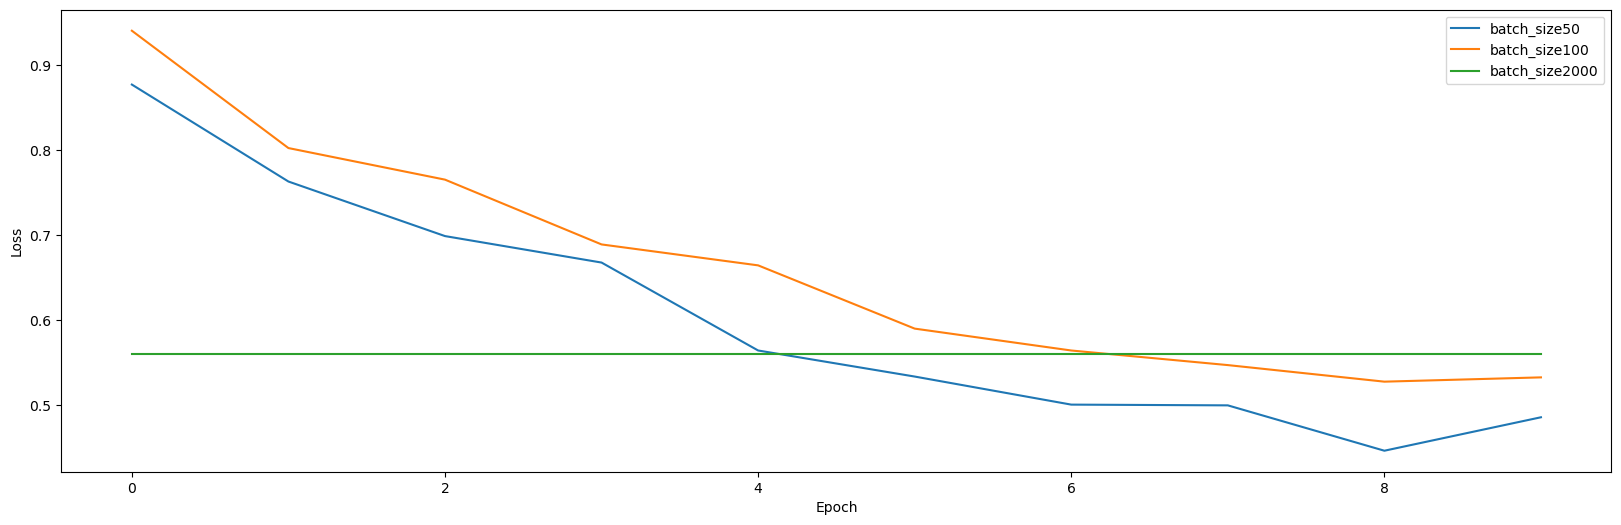

Results after 10 epochs:

Position 1: net1 - loss = 0.486
Position 2: net2 - loss = 0.533
Position 3: net3 - loss = 0.56


In [51]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist10_batch1,label='batch_size50')
plt.plot(loss_val_hist10_batch2,label='batch_size100')
plt.plot(loss_val_hist10_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist10_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

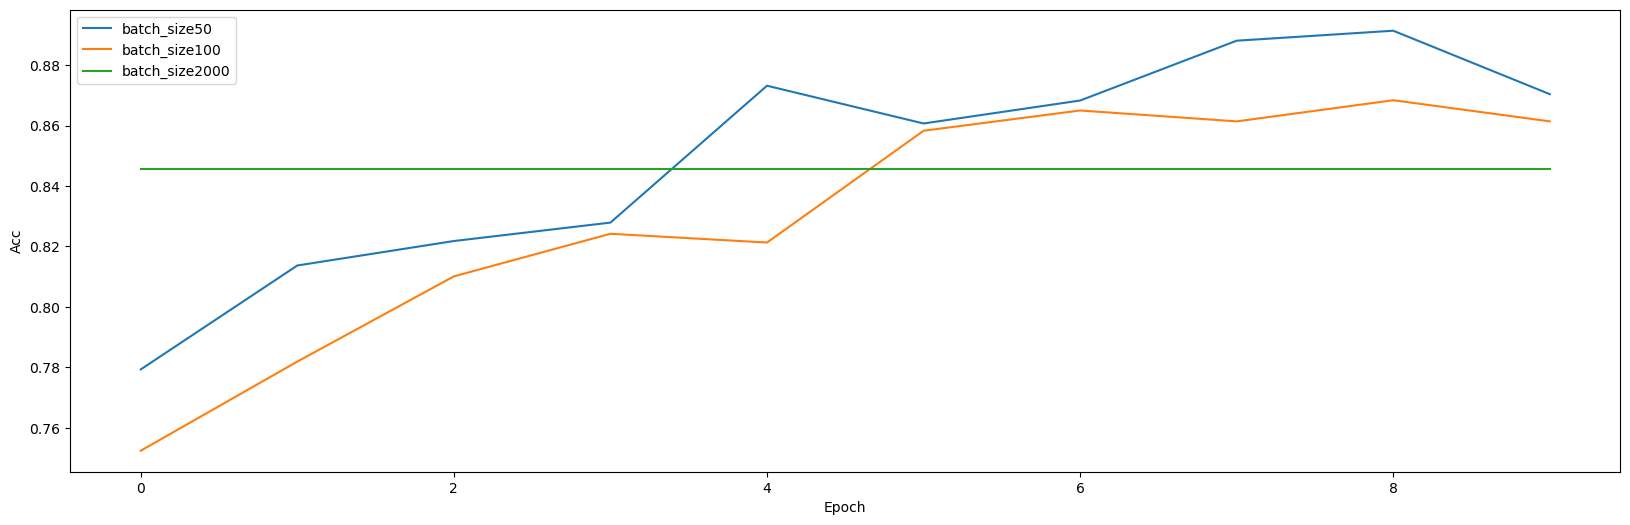

Results after 10 epochs:

Position 1: net1 - loss = 87.04%
Position 2: net2 - loss = 86.14%
Position 3: net3 - loss = 84.57%


In [49]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist10_batch1,label='batch_size50')
plt.plot(acc_val_hist10_batch2,label='batch_size100')
plt.plot(acc_val_hist10_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist10_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(torch.Tensor.numpy(acc_value)*100,3)}%')